# セレクションバイアスを持つ人工データによるCFR_NETの動作検証

In [1]:
import warnings
warnings.filterwarnings('error')
import pandas as pd
import numpy as np
from load_data import IHDP_Dataset
from model import CFR
from optimize import MMD, train
from matplotlib import pyplot as plt
from dowhy import CausalModel

import torch
from torch.utils.data import DataLoader
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# TODO: もう少し結果の見方を工夫する。可視化している結果が意味ない。
def view_causality_data_and_result(D, net, losses, legend=True):
    with torch.no_grad():
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

#         ax1.set_title('potential outcomes')
#         ax1.set_ylabel('$y$')
#         ax1.set_xlabel('$x$')
#         ax1.plot(D.X, D.mu0, label='$mu_0$', color='blue')
#         ax1.plot(D.X, D.mu1, label='$mu_1$', color='orange')

#         tau = D.mu1 - D.mu0
#         N = D.X.shape[0]
#         tau_hat = net(D.X, torch.ones(N))[1] - net(D.X, torch.zeros(N))[1]
#         ax2.set_ylabel('effect')
#         ax2.set_xlabel('$x$')
#         ax2.set_title('ground vs estimate for effect')
#         ax2.plot(D.X, tau, color='blue', label='ground')
#         ax2.plot(D.X, tau_hat, color='orange', label='predict')

        ax3.set_title('train loss')
        ax3.set_ylabel('loss')
        ax3.set_xlabel('steps')
        ax3.plot(losses)
        
        if legend:
            fig.legend()
        fig.tight_layout()
        plt.show()

In [3]:
# データの読み込み
ihdp_train_D = IHDP_Dataset(train=True, mono=True)
ihdp_test_D = train_D = IHDP_Dataset(train=False, mono=True)
ate_true = torch.mean(ihdp_test_D.mu1 - ihdp_test_D.mu0)

In [6]:
# CFR-NETの訓練
train_loader = DataLoader(ihdp_train_D, batch_size=32, shuffle=True)
cfr_net = CFR(feature_dim=25)

model, train_losses, _ = train(cfr_net, train_loader, learning_rate=1e-5, alpha=0.1, seed=100, epoch=100)

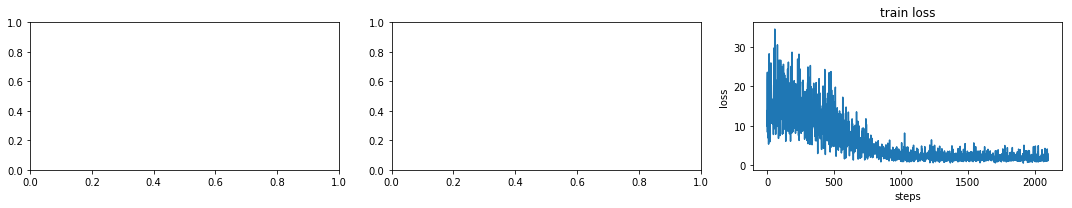

In [7]:
view_causality_data_and_result(ihdp_train_D, model, train_losses, legend=False)

In [14]:
# 結果の評価
def f_treat(X, N):
    '''^f(x, 1)を算出'''
    return cfr_net(X, torch.ones(N))[1]


def f_control(X, N):
    '''^f(x, 0)を算出'''
    return cfr_net(X, torch.zeros(N))[1]


def loss_pehe(y_treat_hat, y_control_hat, mu1, mu0):
    effect_hat = y_treat_hat - y_control_hat  # 効果の推定量
    effect_true = mu1 - mu0  # 真の効果
    return torch.sqrt(torch.mean((effect_hat - effect_true)**2))


def loss_ate(y_treat_hat, y_control_hat, mu1, mu0):
    effect_hat = y_treat_hat - y_control_hat  # 効果の推定量
    effect_true = mu1 - mu0  # 真の効果
    ate_hat = torch.mean(effect_hat)  # ATEの推定量
    ate_true = torch.mean(effect_true)  # 真のATE
    return torch.abs(ate_hat - ate_true)


def evaluation(D, fname):
    # potential outcomeの推定
    y_treat_hat = f_treat(D.x, D.N)
    y_control_hat = f_control(D.x, D.N)

    # \epsilon_{PEHE}を算出
    pehe = loss_pehe(y_treat_hat, y_control_hat, D.mu1, D.mu0)

    # \epsilon_{ATE}を算出
    ate_error = loss_ate(y_treat_hat, y_control_hat, D.mu1, D.mu0)

    # 結果の表示
    print('pehe = ', pehe.item())
    print('error of ate =', ate_error.item())

    # 結果の保存
    torch.save({
        'X_test': D.x,
        'pehe': pehe,
        'ate_error': ate_error,
    }, fname)

In [11]:
# Out of Sample
N = ihdp_test_D.x.shape[0]
estimate_cfr_net = torch.mean(cfr_net(ihdp_test_D.x, torch.ones(N))[1] - cfr_net(ihdp_test_D.x, torch.zeros(N))[1]).item()
print('ATE estimate of CFR-NET: ', estimate_cfr_net)

ATE estimate of CFR-NET:  3.271486520767212


In [18]:
evaluation(ihdp_train_D, 'results/cfr_net_WS.pt')

pehe =  1.2341452836990356
error of ate = 0.740464448928833


In [17]:
evaluation(ihdp_test_D, 'results/cfr_net_OoS.pt')

pehe =  1.2036503553390503
error of ate = 0.7848598957061768
